<a href="https://colab.research.google.com/github/JacPowell/QMUL-Projects/blob/main/Final_Multi_morbidity_Data_VAE_Max_lb_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')



Mounted at /content/drive


In [2]:
#import my_utils as mu
import torch
from torch import nn
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, ConcatDataset
from IPython import display
import math
import torchvision
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold



In [3]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [4]:
#train_data, test_data = torch.utils.data.random_split(full_data_tens, [30000, 10469])

train_path = '/content/drive/MyDrive/Data/MM_train_data'
train_data = torch.load(train_path)
test_path = '/content/drive/MyDrive/Data/MM_test_data'
test_data = torch.load(test_path)


In [5]:
#https://dfdazac.github.io/01-vae.html

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

class BernoulliVAE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, latent_size):
        super(BernoulliVAE, self).__init__()
        # Encoder parameters
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        #self.fc4 = nn.Linear(hidden_size3, latent_size)
        self.lrelu = nn.LeakyReLU(0.1)
        self.enc_mu = nn.Linear(latent_size, latent_size)
        self.enc_logvar = nn.Linear(latent_size, latent_size)

        # Distribution to sample for the reparameterization trick
        self.normal_dist = MultivariateNormal(torch.zeros(latent_size),
                                              torch.eye(latent_size))

        # Decoder parameters
        self.fc5 = nn.Linear(latent_size, hidden_size3)
        self.fc6 = nn.Linear(hidden_size3, hidden_size2)
        self.fc7 = nn.Linear(hidden_size2, hidden_size1)
        self.fc8 = nn.Linear(hidden_size1, input_size)


        # Reconstruction loss: binary cross-entropy
        self.criterion = nn.MSELoss()

    def encode(self, x):
        # Obtain the parameters of the latent variable distribution
        h = self.lrelu(self.fc1(x))
        h = self.lrelu(self.fc2(h))
        h = self.lrelu(self.fc3(h))
        #h = self.lrelu(self.fc4(h))
        mu_e = self.enc_mu(h)
        logvar_e = self.enc_logvar(h)

        # Get a latent variable sample with the reparameterization trick
        epsilon = self.normal_dist.sample((x.shape[0],))
        z = mu_e + torch.sqrt(torch.exp(logvar_e)) * epsilon

        return z, mu_e, logvar_e

    def decode(self, z):
        # Obtain the parameters of the observation distribution
        h = self.lrelu(self.fc5(z))
        h = self.lrelu(self.fc6(h))
        h = self.lrelu(self.fc7(h))
        output = torch.sigmoid(self.fc8(h))

        return output

    def forward(self, x):
        """ Calculate the negative lower bound for the given input """
        z, mu_e, logvar_e = self.encode(x)
        output = self.decode(z)
        MSE_Loss = self.criterion(output, x)
        kl_div = -0.5* (1 + logvar_e - mu_e**2 - torch.exp(logvar_e)).sum()

        # Since the optimizer minimizes, we return the negative
        # of the lower bound that we need to maximize
        return MSE_Loss + kl_div, z, output

In [6]:
#https://github.com/christianversloot/machine-learning-articles/blob/main/
#how-to-use-k-fold-cross-validation-with-pytorch.md

if __name__ == '__main__':
  
  # Configuration options
  k_folds = 5
  epochs = 30
  #loss_function = nn.CrossEntropyLoss()
  loss_function = nn.MSELoss()
  
  # For fold results
  train_results = {}
  val_results = {}
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare dataset by concatenating Train/Test part; we split later.

  dataset = ConcatDataset([test_data, train_data])
  
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=100, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=100, sampler=test_subsampler)
    
    net = BernoulliVAE(input_size=204, 
          hidden_size1=192, 
          hidden_size2=128, 
          hidden_size3=64, 
          latent_size=4)
    net.apply(reset_weights)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)



    # Run the training loop for defined number of epochs
    for epoch in range(1, epochs + 1):
        print(f'\n Epoch {epoch}')
        loss = 0
        training_loss = 0
        test_loss = 0
        val_latents = []
        val_outputs = []
        train_outputs = []
        for i, (batch_features) in enumerate(trainloader):
            optimizer.zero_grad()
            # Reshape data so each image is an array with 204 elements
            batch_features = batch_features.view(-1, 204)

            criterion, z, output = net(batch_features)
            criterion.backward()
            optimizer.step()


            
            train_outputs.append(output.detach().numpy())
            
            train_loss = loss_function(output, batch_features)
            
            # Print statistics
            loss += train_loss.item()
            training_loss += train_loss.item()
            
            

            if i % 100 == 0:
                # Print average loss per sample in batch
                batch_loss = loss/len(batch_features)
                print(f'\r[{i:d}/{len(batch_features):d}] batch loss: {batch_loss} ',
                      end='', flush=True)
            loss = 0
          

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    #print('Starting testing')

    # Evaluation for this fold

    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, (batch_features) in enumerate(testloader):

          # Reshape data so each image is an array with 784 elements
          batch_features = batch_features.view(-1, 204)

          #test_loss = net(batch_features)
          criterion, z, output = net(batch_features)
          
          val_outputs.append(output.detach().numpy())
          val_latents.append(z.detach().numpy())
          val_loss = loss_function(output, batch_features)




          test_loss += val_loss.item()


      train_outputs = np.concatenate( train_outputs, axis=0 )
      val_outputs = np.concatenate( val_outputs, axis=0 )
      val_latents = np.concatenate( val_latents, axis=0 )
      model_train_loss = training_loss / len(train_outputs
                        )
      test_loss = test_loss / len(val_outputs
                        )
      #animator.add(epoch, (loss, test_loss))
      #print(train_iter[0][:5])
      #print(outputs[:5])




      # Print fold loss
      print(f'Training loss for fold {fold}: {model_train_loss}')
      print(f'Validation loss for fold {fold}: {test_loss}')
      print('--------------------------------')
      train_results[fold] = model_train_loss
      val_results[fold] = test_loss
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  train_sum = 0.0
  val_sum = 0.0
  for key, value in train_results.items():
    print(f'Training Fold {key} Loss: {value}')
    train_sum += value
  print(f'Trainig Average Loss: {train_sum/len(train_results.items())}')
  for key, value in val_results.items():
    print(f'Validation Fold {key} Loss: {value} ')
    val_sum += value
  print(f'Vaidation Average Loss: {val_sum/len(val_results.items())}')

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=204, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=4, bias=True)
Reset trainable parameters of layer = Linear(in_features=4, out_features=4, bias=True)
Reset trainable parameters of layer = Linear(in_features=4, out_features=4, bias=True)
Reset trainable parameters of layer = Linear(in_features=4, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=204, bias=True)
Reset trainable parameters of lay

In [7]:
val_latents_df = pd.DataFrame(val_latents)
val_outputs_df = pd.DataFrame(val_outputs)

In [8]:
val_latents_df 

,0,1,2,3
0,-1.198257,1.570128,-0.825886,0.978775
1,1.108362,-0.969913,-0.246809,0.001392
2,0.602519,1.609502,-2.087737,0.590238
3,1.373193,0.692954,1.621618,0.125304
4,0.877004,-0.758017,-0.740994,1.382120
...,...,...,...,...
8088,1.551683,-0.005114,-0.185250,0.754222
8089,-0.990200,-1.068084,-0.688829,1.192176
8090,-0.455143,0.309010,-0.565373,1.605648
8091,-1.191337,2.588262,-1.211382,-1.097311


In [9]:
val_outputs_df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.003466,0.006530,0.095589,0.155407,0.003998,0.003735,0.234528,0.013270,0.008724,0.007341,...,0.736817,0.015023,0.813410,0.135977,0.066996,0.054063,0.093405,0.087724,0.076439,0.007200
1,0.003891,0.007495,0.100912,0.161317,0.004488,0.004201,0.241298,0.014913,0.009844,0.008258,...,0.732052,0.016965,0.808145,0.140843,0.071247,0.058436,0.098887,0.093410,0.081169,0.008067
2,0.002932,0.005891,0.091966,0.150943,0.003447,0.003203,0.231966,0.012120,0.007858,0.006489,...,0.740591,0.013918,0.818463,0.131895,0.063670,0.051666,0.090187,0.085281,0.074030,0.006296
3,0.003801,0.007195,0.099820,0.159356,0.004370,0.004089,0.239376,0.014347,0.009550,0.008024,...,0.733662,0.016402,0.809081,0.139427,0.070022,0.057484,0.097600,0.091880,0.080281,0.007814
4,0.003840,0.007471,0.101692,0.161454,0.004418,0.004152,0.241092,0.014948,0.009836,0.008202,...,0.731543,0.016987,0.808164,0.141059,0.071002,0.058571,0.098734,0.093627,0.081345,0.007985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,0.003974,0.007369,0.100101,0.159676,0.004542,0.004271,0.239739,0.014631,0.009755,0.008223,...,0.733446,0.016532,0.808812,0.139828,0.070474,0.057527,0.098113,0.092208,0.080509,0.008062
8089,0.004530,0.008384,0.105631,0.165414,0.005131,0.004863,0.244772,0.016453,0.010947,0.009211,...,0.727278,0.018386,0.803807,0.144797,0.074725,0.061489,0.102217,0.096933,0.084246,0.009021
8090,0.003812,0.007169,0.099317,0.158745,0.004383,0.004089,0.238434,0.014407,0.009461,0.007955,...,0.733549,0.016173,0.810497,0.139090,0.069644,0.056767,0.096425,0.091082,0.079269,0.007801
8091,0.002933,0.005637,0.090969,0.149740,0.003370,0.003170,0.229794,0.011662,0.007498,0.006327,...,0.741988,0.013194,0.819356,0.130488,0.062907,0.049557,0.088217,0.082441,0.071324,0.006231


In [10]:
val_latents_df.corr()

,0,1,2,3
0,1.000000,0.002219,-0.018997,0.004898
1,0.002219,1.000000,-0.019442,-0.015094
2,-0.018997,-0.019442,1.000000,-0.007535
3,0.004898,-0.015094,-0.007535,1.000000


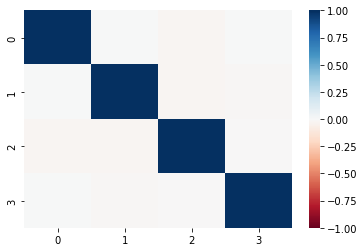

In [11]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

dataplot = sb.heatmap(val_latents_df.corr(), cmap="RdBu", vmin=-1, vmax=1)

In [12]:
val_outputs_df['mean'] = val_outputs_df.mean(axis=0)


"a3.set_title('Input data vs autocoder generated data mean')\na3.plot(test_data.mean(), label = 'Sample Input Mean')\na3.plot(val_outputs_df['mean'], label = 'Sample Output Mean')\na3.set_ylabel('Value')\na3.set_xlabel('Variable')\na3.legend()"

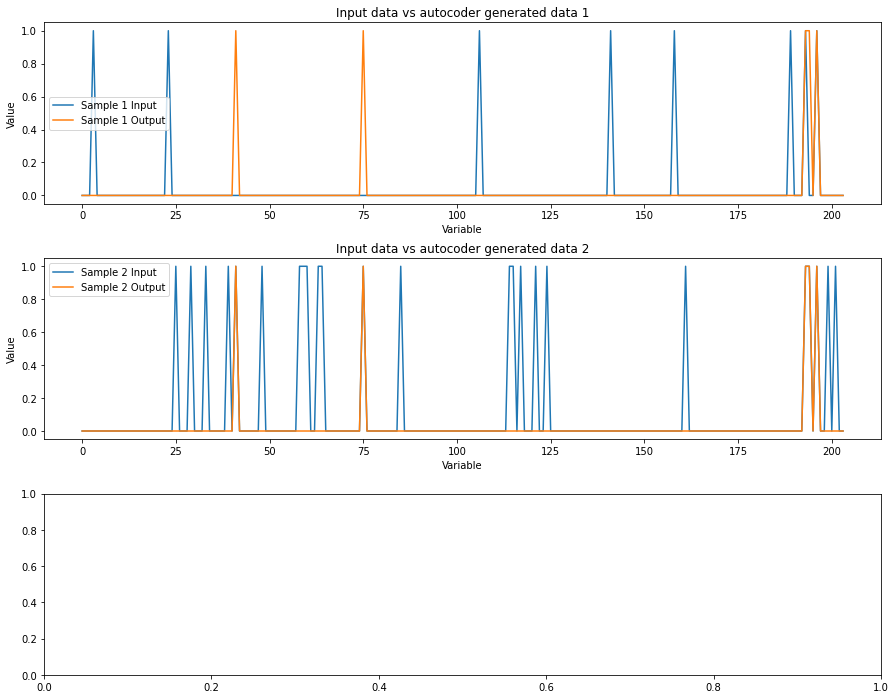

In [13]:
import matplotlib.pyplot as plt

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace = 0.3)
a1.set_title('Input data vs autocoder generated data 1')
a1.plot(test_data[0], label = 'Sample 1 Input')
a1.plot(val_outputs[0].round(), label = 'Sample 1 Output')
a1.set_ylabel('Value')
a1.set_xlabel('Variable')
a1.legend()

a2.set_title('Input data vs autocoder generated data 2')
a2.plot(test_data[1], label = 'Sample 2 Input')
a2.plot(val_outputs[1].round(), label = 'Sample 2 Output')
a2.set_ylabel('Value')
a2.set_xlabel('Variable')
a2.legend()

'''a3.set_title('Input data vs autocoder generated data mean')
a3.plot(test_data.mean(), label = 'Sample Input Mean')
a3.plot(val_outputs_df['mean'], label = 'Sample Output Mean')
a3.set_ylabel('Value')
a3.set_xlabel('Variable')
a3.legend()'''

In [14]:
#dataplot = sb.heatmap(val_outputs_df.corr(), cmap="YlGnBu")

In [15]:
mean = val_latents.mean(axis=0)
mean = torch.from_numpy(mean)
std = val_latents.std(axis=0)
std = torch.from_numpy(std)




In [16]:
print(std)
print(mean)

tensor([1.0107, 1.0046, 0.9812, 1.0128])
tensor([-0.0039, -0.0172,  0.0036, -0.0018])


In [17]:
gen_lat = torch.normal(mean=mean, std=std)

gen_data = net.decode(gen_lat)



In [18]:
gen_data = gen_data.detach().numpy()

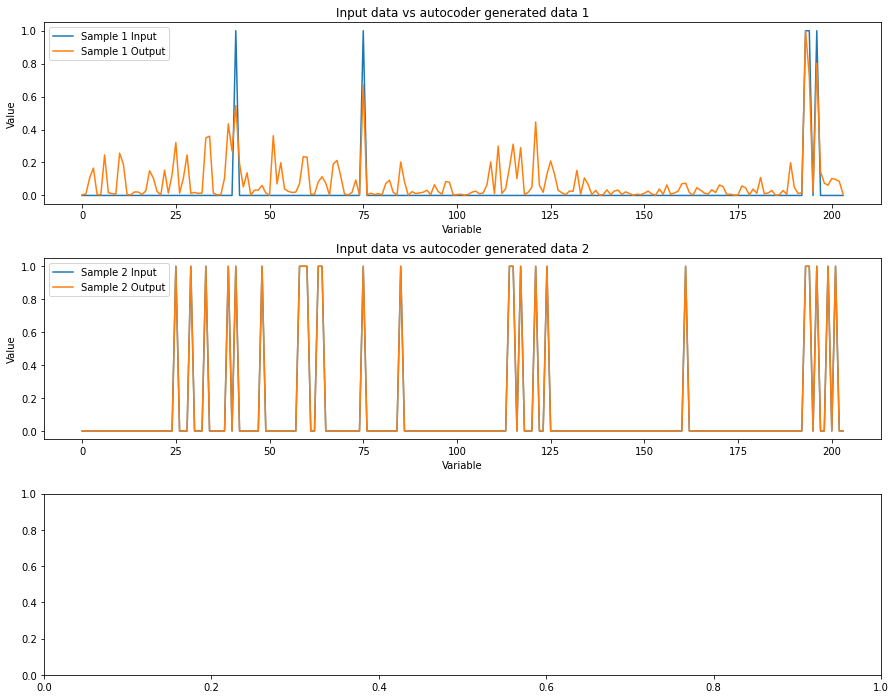

In [19]:
fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace = 0.3)
a1.set_title('Input data vs autocoder generated data 1')
a1.plot(gen_data.round(), label = 'Sample 1 Input')
a1.plot(gen_data, label = 'Sample 1 Output')
a1.set_ylabel('Value')
a1.set_xlabel('Variable')
a1.legend()

a2.set_title('Input data vs autocoder generated data 2')
a2.plot(test_data[1], label = 'Sample 2 Input')
a2.plot(test_data[1], label = 'Sample 2 Output')
a2.set_ylabel('Value')
a2.set_xlabel('Variable')
a2.legend()